## Slow Feature Analysis
#### Exercise 1: Slow Feature Analysis on two independent signals

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
import seaborn as sns
sns.set(palette='Set2')

Write a function that generates a random signal of length T (number of samples) that has an average frequency spectrum corresponding to $PSD(k)= e^{(- \frac{k^2} {2 \epsilon})}$:

In [11]:
def low_signal(rand_signal, epsilon, sample_period):
    
    fft_rand_signal = np.fft.fft( rand_signal )
    frq_rand_signal = np.fft.fftfreq( rand_signal.size, sample_period )
    
    filter_low = np.sqrt(np.exp(- frq_rand_signal**2/ (2*epsilon)))
    filter_low = filter_low / np.sum(filter_low)
   
    filter_fft_rand_signal = fft_rand_signal*filter_low
    filter_rand_signal = np.real(np.fft.ifft( filter_fft_rand_signal ))
    return filter_rand_signal;


Use the function from the task above to generate two independent 1D-signals, with a PSD(k) where $\epsilon = \frac{1}{\tau^2}$. Normalise the signals, so that both have zero mean and unit variance. Plot both signals into a single figure. How does $\tau$ influence the characteristics of the signals?

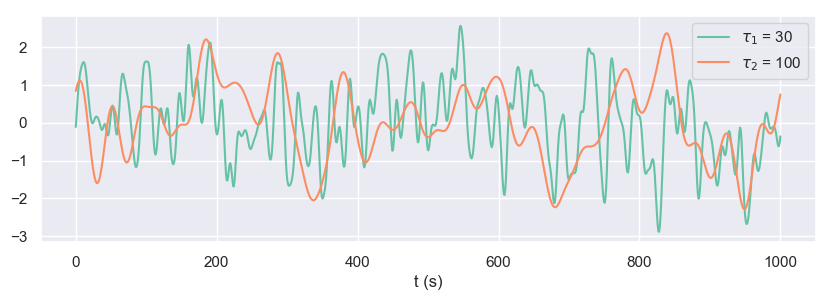

In [12]:
tau1 = 30
tau2 = 100
e1 = 1/(tau1**2)
e2 = 1/(tau2**2)

T = 1000 #number of samples
dt = 1
t = np.linspace(0, T*dt, T) #time axis

s_rand1 = np.random.random(T);
s_rand2 = np.random.random(T);

k = np.fft.fftfreq(T, d=dt) #fequency axis

s1 = low_signal(s_rand1, e1, dt)
s2 = low_signal(s_rand2, e2, dt)

x1 = (s1 - np.mean(s1))/(np.std(s1))
x2 = (s2 - np.mean(s2))/(np.std(s2))

plt.figure(figsize=(10,3), dpi=100)
plt.plot(t, x1, label=r'$\tau_1$ = {}'.format(tau1))
plt.plot(t, x2, label=r'$\tau_2$ = {}'.format(tau2))
plt.xlabel('t (s)')
plt.legend(loc=1)
plt.show()

Through $\epsilon$, we use $\tau$ to design the lowpass filter used to create the two signals out of random signals. The higher $\tau$ is, the more a frequency of the original random signal will be attenuated. Thus, $\tau$ can be interpreted as the "rapidity" of the signals, with $x_2$ having a higher low-frequency content (as visible in the plot).

We will now perform linear SFA to see whether we can generate a slow signal by linearly combining both signals. Compute the joint covariance matrix of both signals  as well as the matrix of second moments of the temporal derivative. Next, to perform SFA, we need to solve the Generalised Eigenvalue Problem of both matrices.

In [13]:
X = np.vstack((x1, x2))
C = np.cov(X)
dX = np.diff(X)/dt
dC = np.dot(dX, dX.T)/(T-1)
w_comp, v = sp.linalg.eig(dC, C)
w = w_comp.real

The eigenvectors determine how the input signals are mixed by the SFA to generate the new (slow) signals. What kind of mixture do you ideally expect given how the data was generated? What does the empirical mixture look like, judging from the extracted eigenvectors?

Given that the two signals were randomly generated, therefore are indipendent, I expect the two eigenvectors to be orthogonal. The extracted egenvectors and their correspondent eigenvalues are: 

In [14]:
[print('w{}: {}, v{}: {}'.format(i, w[i], i, v[:,i])) for i in range(len(w))]

w0: 0.042636575079536124, v0: [-0.97390851  0.22694101]
w1: 0.004329693827090184, v1: [-0.00702335  0.99997534]


[None, None]

The actual eigenvectors are not completely orthogonal:

In [17]:
np.dot(v[:,0],v[:,1])

0.2337755093441574

Since minimizing the objective function of this optimization problem (time-avaraged squared derivative over time) is equivalent to minimizing the eigenvalues, we can interpret the eigenvector with the least eigenvalue to be the direction of least variance over time. 

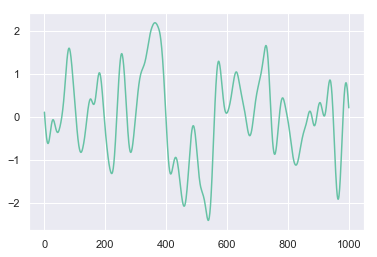

In [8]:
ws = v[:, 1]
y2 = ws[0]*x1 + ws[1]*x2
plt.plot(y2);

Repeat task 3 with different signal sample sizes and store the resulting normalised eigenvectors. Plot the four individual components of the eigenvectors against the number of samples. How does the SFA-mixture change depending on the length of the input signal? Can you give an intuition why?

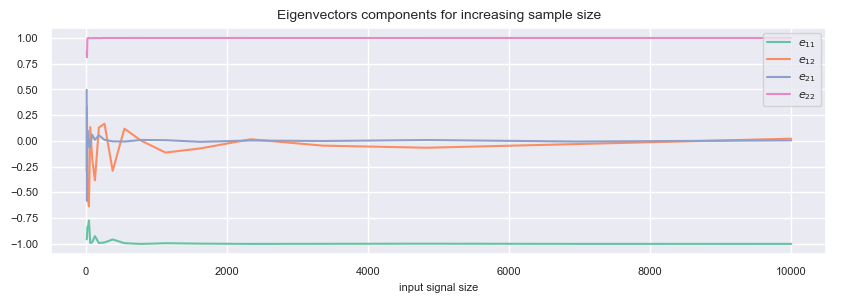

In [39]:
T = np.logspace(1, 4, 20, dtype='int')

def sfa (size):
    
    dt = 1
    
    #generate two signals filtered by a lpf
    s1 = low_signal(np.random.random(size), e1, dt)
    s2 = low_signal(np.random.random(size), e2, dt)
    
    #normalize the signals
    x1 = (s1 - np.mean(s1))/(np.std(s1))
    x2 = (s2 - np.mean(s2))/(np.std(s2))
    
    
    X = np.vstack((x1, x2)) 
    C = np.cov(X)
    dX = np.diff(X)/dt
    dC = np.dot(dX, dX.T)/(size-1)
    w, v = sp.linalg.eig(dC, C)
    return v;

V = []; #eigenvector matrix
for size in T:
    V.append(sfa(size));

V = np.array(V)

v1 = np.array([V[i][0][0] for i in range(0, len(T))])
v2 = np.array([V[i][1][0] for i in range(0, len(T))])
v3 = np.array([V[i][0][1] for i in range(0, len(T))])
v4 = np.array([V[i][1][1] for i in range(0, len(T))])

plt.figure(figsize=(10, 3), dpi=100)
plt.plot(T, v1, label=r'$e_{11}$')
plt.plot(T, v2, label=r'$e_{12}$')
plt.plot(T, v3, label=r'$e_{21}$')
plt.plot(T, v4, label=r'$e_{22}$')
#plt.xscale('log')
plt.xlabel('input signal size', fontsize=8)
plt.yticks(np.linspace(-1, 1, 9), fontsize=8)
plt.xticks(fontsize=8)
plt.legend(fontsize=8)
plt.title('Eigenvectors components for increasing sample size', fontsize=10)
plt.show()

Longer signals are less subject to errors, thus the four components of the eigenvectors will stabilize towards their ideal value for higher sample sizes.

How do the eigenvalues depend on the $\tau$'s that you chose?

The eigenvalues $\lambda_{1, 2}$ indicate which are the 'slowest' directions in the space C (the lowest $\lambda$'s are the slowest directions), thus the higher $\tau_i$ is, the lower $\lambda_i$ is going to be.